In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_addons as tfa

In [2]:
TRAIN_DIR = '../data/cancerous/training'
TEST_DIR = '../data/cancerous/testing'
VAL_DIR = '../data/cancerous/validation'
# INPUT_WIDTH = 27
# INPUT_HEIGHT = 27

BATCH_SIZE = 128
IMG_SIZE = (32, 32)


train_dataset = image_dataset_from_directory(TRAIN_DIR,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             interpolation='nearest',
                                             label_mode='categorical'
                                            )

validation_dataset = image_dataset_from_directory(VAL_DIR,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  interpolation='nearest',
                                                  label_mode='categorical'
                                            )

test_dataset = image_dataset_from_directory(TEST_DIR,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  interpolation='nearest',
                                                  label_mode='categorical'
                                            )

Found 16223 files belonging to 2 classes.
Found 2028 files belonging to 2 classes.
Found 2029 files belonging to 2 classes.


In [3]:
def get_class_name(class_num):
    if class_num == 0:
        return 'non-cancerous'
    elif class_num == 1:
        return 'cancerous'

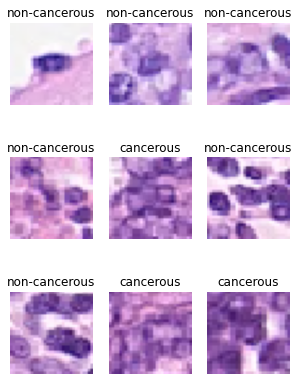

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(5, 7))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(get_class_name(tf.where(tf.equal(labels[i], 1)).numpy()[0][0]))
        plt.axis("off")

In [5]:
train_dataset.class_names

['0', '1']

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

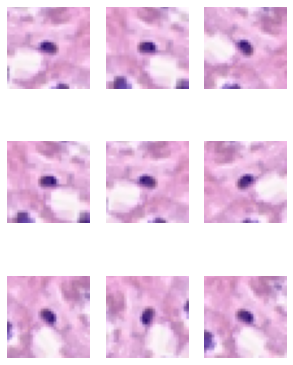

In [8]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(5, 7))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [11]:
# Create the base model from the MobileNetV2 model without loading pretrained-weights
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)

In [12]:
# image_batch, label_batch = next(iter(train_dataset))
# feature_batch = base_model(image_batch)
# print(feature_batch.shape)

In [13]:
for layer in base_model.layers:
    layer.trainable = True

In [14]:
# base_model.trainable = False

In [15]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 16, 16, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 16, 16, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 16, 16, 32)   0           bn_Conv1[0][0]                   
________________________________________________________________________________

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

In [17]:
prediction_layer = tf.keras.layers.Dense(2)
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [18]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', f1_score ,precision_m, recall_m])

/home/trungngo/Desktop/venv/colon-cancer-classification/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [21]:
len(model.trainable_variables)

158

In [22]:
epochs = 500

loss0, accuracy0, f1_0, precision0, recall0 = model.evaluate(validation_dataset)

16/16 [==============================] - 3s 14ms/step - loss: 0.7717 - accuracy: 0.5636 - f1_score: 0.3941 - precision_m: 0.5736 - recall_m: 0.3006


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.77
initial accuracy: 0.56


In [24]:
import time
start_time = time.time()

In [25]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)

Epoch 1/500
127/127 [==============================] - 5s 20ms/step - loss: 0.7139 - accuracy: 0.6099 - f1_score: 0.4498 - precision_m: 0.6177 - recall_m: 0.3547 - val_loss: 0.6501 - val_accuracy: 0.6391 - val_f1_score: 0.4296 - val_precision_m: 0.6622 - val_recall_m: 0.3182
Epoch 2/500
127/127 [==============================] - 2s 18ms/step - loss: 0.6633 - accuracy: 0.6405 - f1_score: 0.4723 - precision_m: 0.6592 - recall_m: 0.3689 - val_loss: 0.6312 - val_accuracy: 0.6657 - val_f1_score: 0.4805 - val_precision_m: 0.7013 - val_recall_m: 0.3660
Epoch 3/500
127/127 [==============================] - 2s 17ms/step - loss: 0.6131 - accuracy: 0.6790 - f1_score: 0.5143 - precision_m: 0.7029 - recall_m: 0.4063 - val_loss: 0.6004 - val_accuracy: 0.7066 - val_f1_score: 0.5452 - val_precision_m: 0.7560 - val_recall_m: 0.4267
Epoch 4/500
127/127 [==============================] - 2s 17ms/step - loss: 0.5630 - accuracy: 0.7157 - f1_score: 0.5572 - precision_m: 0.7619 - recall_m: 0.4402 - val_loss

Epoch 31/500
127/127 [==============================] - 2s 17ms/step - loss: 0.2938 - accuracy: 0.8733 - f1_score: 0.8365 - precision_m: 0.9267 - recall_m: 0.7628 - val_loss: 0.3147 - val_accuracy: 0.8634 - val_f1_score: 0.8322 - val_precision_m: 0.9122 - val_recall_m: 0.7655
Epoch 32/500
127/127 [==============================] - 2s 17ms/step - loss: 0.2891 - accuracy: 0.8785 - f1_score: 0.8432 - precision_m: 0.9313 - recall_m: 0.7708 - val_loss: 0.3119 - val_accuracy: 0.8595 - val_f1_score: 0.8274 - val_precision_m: 0.9251 - val_recall_m: 0.7488
Epoch 33/500
127/127 [==============================] - 2s 17ms/step - loss: 0.2867 - accuracy: 0.8763 - f1_score: 0.8400 - precision_m: 0.9356 - recall_m: 0.7625 - val_loss: 0.3065 - val_accuracy: 0.8664 - val_f1_score: 0.8274 - val_precision_m: 0.9260 - val_recall_m: 0.7480
Epoch 34/500
127/127 [==============================] - 2s 17ms/step - loss: 0.2877 - accuracy: 0.8788 - f1_score: 0.8335 - precision_m: 0.9352 - recall_m: 0.7524 - val_

Epoch 61/500
127/127 [==============================] - 3s 25ms/step - loss: 0.2442 - accuracy: 0.8955 - f1_score: 0.8586 - precision_m: 0.9516 - recall_m: 0.7826 - val_loss: 0.2638 - val_accuracy: 0.8935 - val_f1_score: 0.8578 - val_precision_m: 0.9459 - val_recall_m: 0.7853
Epoch 62/500
127/127 [==============================] - 3s 21ms/step - loss: 0.2431 - accuracy: 0.8987 - f1_score: 0.8572 - precision_m: 0.9533 - recall_m: 0.7792 - val_loss: 0.2654 - val_accuracy: 0.8905 - val_f1_score: 0.8485 - val_precision_m: 0.9495 - val_recall_m: 0.7677
Epoch 63/500
127/127 [==============================] - 3s 24ms/step - loss: 0.2387 - accuracy: 0.8996 - f1_score: 0.8649 - precision_m: 0.9522 - recall_m: 0.7927 - val_loss: 0.2622 - val_accuracy: 0.8925 - val_f1_score: 0.8616 - val_precision_m: 0.9468 - val_recall_m: 0.7909
Epoch 64/500
127/127 [==============================] - 3s 21ms/step - loss: 0.2388 - accuracy: 0.8998 - f1_score: 0.8660 - precision_m: 0.9518 - recall_m: 0.7949 - val_

Epoch 91/500
127/127 [==============================] - 2s 18ms/step - loss: 0.1994 - accuracy: 0.9194 - f1_score: 0.8971 - precision_m: 0.9577 - recall_m: 0.8442 - val_loss: 0.2519 - val_accuracy: 0.9098 - val_f1_score: 0.8774 - val_precision_m: 0.9405 - val_recall_m: 0.8224
Epoch 92/500
127/127 [==============================] - 2s 19ms/step - loss: 0.1982 - accuracy: 0.9198 - f1_score: 0.8989 - precision_m: 0.9570 - recall_m: 0.8478 - val_loss: 0.2451 - val_accuracy: 0.9048 - val_f1_score: 0.8840 - val_precision_m: 0.9447 - val_recall_m: 0.8310
Epoch 93/500
127/127 [==============================] - 2s 19ms/step - loss: 0.1925 - accuracy: 0.9205 - f1_score: 0.8983 - precision_m: 0.9602 - recall_m: 0.8442 - val_loss: 0.2430 - val_accuracy: 0.9088 - val_f1_score: 0.8925 - val_precision_m: 0.9406 - val_recall_m: 0.8493
Epoch 94/500
127/127 [==============================] - 3s 21ms/step - loss: 0.1946 - accuracy: 0.9213 - f1_score: 0.8998 - precision_m: 0.9595 - recall_m: 0.8476 - val_

127/127 [==============================] - 2s 20ms/step - loss: 0.1619 - accuracy: 0.9336 - f1_score: 0.9145 - precision_m: 0.9702 - recall_m: 0.8652 - val_loss: 0.2538 - val_accuracy: 0.9132 - val_f1_score: 0.8949 - val_precision_m: 0.9407 - val_recall_m: 0.8537
Epoch 121/500
127/127 [==============================] - 2s 18ms/step - loss: 0.1678 - accuracy: 0.9312 - f1_score: 0.9146 - precision_m: 0.9675 - recall_m: 0.8676 - val_loss: 0.2416 - val_accuracy: 0.9088 - val_f1_score: 0.8870 - val_precision_m: 0.9451 - val_recall_m: 0.8360
Epoch 122/500
127/127 [==============================] - 2s 18ms/step - loss: 0.1627 - accuracy: 0.9356 - f1_score: 0.9161 - precision_m: 0.9680 - recall_m: 0.8699 - val_loss: 0.2594 - val_accuracy: 0.9043 - val_f1_score: 0.8878 - val_precision_m: 0.9414 - val_recall_m: 0.8404
Epoch 123/500
127/127 [==============================] - 3s 21ms/step - loss: 0.1643 - accuracy: 0.9333 - f1_score: 0.9140 - precision_m: 0.9669 - recall_m: 0.8669 - val_loss: 0.24

127/127 [==============================] - 2s 18ms/step - loss: 0.1446 - accuracy: 0.9423 - f1_score: 0.9263 - precision_m: 0.9723 - recall_m: 0.8847 - val_loss: 0.2533 - val_accuracy: 0.9093 - val_f1_score: 0.8960 - val_precision_m: 0.9397 - val_recall_m: 0.8565
Epoch 150/500
127/127 [==============================] - 2s 19ms/step - loss: 0.1406 - accuracy: 0.9434 - f1_score: 0.9277 - precision_m: 0.9733 - recall_m: 0.8865 - val_loss: 0.2426 - val_accuracy: 0.9167 - val_f1_score: 0.8960 - val_precision_m: 0.9438 - val_recall_m: 0.8529
Epoch 151/500
127/127 [==============================] - 3s 21ms/step - loss: 0.1378 - accuracy: 0.9446 - f1_score: 0.9276 - precision_m: 0.9744 - recall_m: 0.8853 - val_loss: 0.2378 - val_accuracy: 0.9122 - val_f1_score: 0.9036 - val_precision_m: 0.9419 - val_recall_m: 0.8685
Epoch 152/500
127/127 [==============================] - 3s 22ms/step - loss: 0.1404 - accuracy: 0.9435 - f1_score: 0.9276 - precision_m: 0.9729 - recall_m: 0.8867 - val_loss: 0.25

127/127 [==============================] - 2s 19ms/step - loss: 0.1222 - accuracy: 0.9519 - f1_score: 0.9384 - precision_m: 0.9765 - recall_m: 0.9035 - val_loss: 0.2515 - val_accuracy: 0.9137 - val_f1_score: 0.9025 - val_precision_m: 0.9409 - val_recall_m: 0.8674
Epoch 179/500
127/127 [==============================] - 2s 19ms/step - loss: 0.1213 - accuracy: 0.9517 - f1_score: 0.9407 - precision_m: 0.9768 - recall_m: 0.9075 - val_loss: 0.2582 - val_accuracy: 0.9167 - val_f1_score: 0.9024 - val_precision_m: 0.9382 - val_recall_m: 0.8694
Epoch 180/500
127/127 [==============================] - 3s 23ms/step - loss: 0.1160 - accuracy: 0.9536 - f1_score: 0.9409 - precision_m: 0.9782 - recall_m: 0.9066 - val_loss: 0.2767 - val_accuracy: 0.9147 - val_f1_score: 0.9074 - val_precision_m: 0.9364 - val_recall_m: 0.8806
Epoch 181/500
127/127 [==============================] - 3s 20ms/step - loss: 0.1196 - accuracy: 0.9513 - f1_score: 0.9388 - precision_m: 0.9773 - recall_m: 0.9034 - val_loss: 0.26

127/127 [==============================] - 2s 17ms/step - loss: 0.1083 - accuracy: 0.9559 - f1_score: 0.9455 - precision_m: 0.9796 - recall_m: 0.9140 - val_loss: 0.2735 - val_accuracy: 0.9117 - val_f1_score: 0.8985 - val_precision_m: 0.9366 - val_recall_m: 0.8638
Epoch 208/500
127/127 [==============================] - 2s 18ms/step - loss: 0.1018 - accuracy: 0.9613 - f1_score: 0.9496 - precision_m: 0.9797 - recall_m: 0.9216 - val_loss: 0.2708 - val_accuracy: 0.9122 - val_f1_score: 0.9072 - val_precision_m: 0.9378 - val_recall_m: 0.8785
Epoch 209/500
127/127 [==============================] - 2s 18ms/step - loss: 0.1019 - accuracy: 0.9572 - f1_score: 0.9476 - precision_m: 0.9802 - recall_m: 0.9173 - val_loss: 0.2550 - val_accuracy: 0.9152 - val_f1_score: 0.9054 - val_precision_m: 0.9393 - val_recall_m: 0.8742
Epoch 210/500
127/127 [==============================] - 2s 19ms/step - loss: 0.1008 - accuracy: 0.9607 - f1_score: 0.9501 - precision_m: 0.9801 - recall_m: 0.9222 - val_loss: 0.26

127/127 [==============================] - 2s 18ms/step - loss: 0.0829 - accuracy: 0.9656 - f1_score: 0.9592 - precision_m: 0.9844 - recall_m: 0.9355 - val_loss: 0.3206 - val_accuracy: 0.9142 - val_f1_score: 0.9044 - val_precision_m: 0.9374 - val_recall_m: 0.8739
Epoch 237/500
127/127 [==============================] - 3s 20ms/step - loss: 0.0842 - accuracy: 0.9676 - f1_score: 0.9592 - precision_m: 0.9843 - recall_m: 0.9354 - val_loss: 0.2997 - val_accuracy: 0.9181 - val_f1_score: 0.9096 - val_precision_m: 0.9400 - val_recall_m: 0.8813
Epoch 238/500
127/127 [==============================] - 3s 21ms/step - loss: 0.0850 - accuracy: 0.9660 - f1_score: 0.9587 - precision_m: 0.9840 - recall_m: 0.9349 - val_loss: 0.2950 - val_accuracy: 0.9098 - val_f1_score: 0.9029 - val_precision_m: 0.9367 - val_recall_m: 0.8717
Epoch 239/500
127/127 [==============================] - 3s 20ms/step - loss: 0.0869 - accuracy: 0.9654 - f1_score: 0.9560 - precision_m: 0.9828 - recall_m: 0.9309 - val_loss: 0.29

127/127 [==============================] - 2s 18ms/step - loss: 0.0719 - accuracy: 0.9719 - f1_score: 0.9667 - precision_m: 0.9858 - recall_m: 0.9484 - val_loss: 0.3135 - val_accuracy: 0.9132 - val_f1_score: 0.9090 - val_precision_m: 0.9287 - val_recall_m: 0.8904
Epoch 266/500
127/127 [==============================] - 3s 20ms/step - loss: 0.0723 - accuracy: 0.9718 - f1_score: 0.9659 - precision_m: 0.9854 - recall_m: 0.9474 - val_loss: 0.3357 - val_accuracy: 0.9172 - val_f1_score: 0.9089 - val_precision_m: 0.9292 - val_recall_m: 0.8895
Epoch 267/500
127/127 [==============================] - 3s 20ms/step - loss: 0.0727 - accuracy: 0.9714 - f1_score: 0.9638 - precision_m: 0.9854 - recall_m: 0.9434 - val_loss: 0.3521 - val_accuracy: 0.9117 - val_f1_score: 0.9087 - val_precision_m: 0.9324 - val_recall_m: 0.8864
Epoch 268/500
127/127 [==============================] - 2s 19ms/step - loss: 0.0739 - accuracy: 0.9718 - f1_score: 0.9651 - precision_m: 0.9859 - recall_m: 0.9452 - val_loss: 0.29

127/127 [==============================] - 2s 19ms/step - loss: 0.0645 - accuracy: 0.9758 - f1_score: 0.9692 - precision_m: 0.9875 - recall_m: 0.9516 - val_loss: 0.3305 - val_accuracy: 0.9063 - val_f1_score: 0.9009 - val_precision_m: 0.9273 - val_recall_m: 0.8761
Epoch 295/500
127/127 [==============================] - 2s 19ms/step - loss: 0.0687 - accuracy: 0.9745 - f1_score: 0.9671 - precision_m: 0.9856 - recall_m: 0.9495 - val_loss: 0.3295 - val_accuracy: 0.9078 - val_f1_score: 0.9041 - val_precision_m: 0.9288 - val_recall_m: 0.8808
Epoch 296/500
127/127 [==============================] - 2s 20ms/step - loss: 0.0674 - accuracy: 0.9755 - f1_score: 0.9700 - precision_m: 0.9875 - recall_m: 0.9533 - val_loss: 0.3313 - val_accuracy: 0.9088 - val_f1_score: 0.9043 - val_precision_m: 0.9267 - val_recall_m: 0.8830
Epoch 297/500
127/127 [==============================] - 2s 19ms/step - loss: 0.0637 - accuracy: 0.9752 - f1_score: 0.9693 - precision_m: 0.9863 - recall_m: 0.9529 - val_loss: 0.31

127/127 [==============================] - 2s 19ms/step - loss: 0.0571 - accuracy: 0.9780 - f1_score: 0.9736 - precision_m: 0.9893 - recall_m: 0.9585 - val_loss: 0.3706 - val_accuracy: 0.9093 - val_f1_score: 0.9087 - val_precision_m: 0.9276 - val_recall_m: 0.8907
Epoch 324/500
127/127 [==============================] - 2s 19ms/step - loss: 0.0570 - accuracy: 0.9776 - f1_score: 0.9737 - precision_m: 0.9896 - recall_m: 0.9585 - val_loss: 0.3224 - val_accuracy: 0.9172 - val_f1_score: 0.9119 - val_precision_m: 0.9366 - val_recall_m: 0.8887
Epoch 325/500
127/127 [==============================] - 2s 18ms/step - loss: 0.0595 - accuracy: 0.9792 - f1_score: 0.9733 - precision_m: 0.9884 - recall_m: 0.9587 - val_loss: 0.3284 - val_accuracy: 0.9142 - val_f1_score: 0.9118 - val_precision_m: 0.9298 - val_recall_m: 0.8945
Epoch 326/500
127/127 [==============================] - 2s 19ms/step - loss: 0.0586 - accuracy: 0.9776 - f1_score: 0.9734 - precision_m: 0.9886 - recall_m: 0.9587 - val_loss: 0.31

127/127 [==============================] - 3s 21ms/step - loss: 0.0539 - accuracy: 0.9785 - f1_score: 0.9738 - precision_m: 0.9896 - recall_m: 0.9585 - val_loss: 0.3315 - val_accuracy: 0.9196 - val_f1_score: 0.9131 - val_precision_m: 0.9412 - val_recall_m: 0.8867
Epoch 353/500
127/127 [==============================] - 2s 17ms/step - loss: 0.0516 - accuracy: 0.9797 - f1_score: 0.9768 - precision_m: 0.9902 - recall_m: 0.9638 - val_loss: 0.3262 - val_accuracy: 0.9167 - val_f1_score: 0.9081 - val_precision_m: 0.9325 - val_recall_m: 0.8851
Epoch 354/500
127/127 [==============================] - 2s 19ms/step - loss: 0.0487 - accuracy: 0.9816 - f1_score: 0.9774 - precision_m: 0.9910 - recall_m: 0.9644 - val_loss: 0.3712 - val_accuracy: 0.9132 - val_f1_score: 0.9097 - val_precision_m: 0.9304 - val_recall_m: 0.8900
Epoch 355/500
127/127 [==============================] - 2s 18ms/step - loss: 0.0499 - accuracy: 0.9810 - f1_score: 0.9770 - precision_m: 0.9907 - recall_m: 0.9638 - val_loss: 0.37

127/127 [==============================] - 2s 18ms/step - loss: 0.0469 - accuracy: 0.9828 - f1_score: 0.9782 - precision_m: 0.9909 - recall_m: 0.9659 - val_loss: 0.3851 - val_accuracy: 0.9196 - val_f1_score: 0.9182 - val_precision_m: 0.9314 - val_recall_m: 0.9053
Epoch 382/500
127/127 [==============================] - 3s 20ms/step - loss: 0.0443 - accuracy: 0.9831 - f1_score: 0.9806 - precision_m: 0.9917 - recall_m: 0.9699 - val_loss: 0.3427 - val_accuracy: 0.9186 - val_f1_score: 0.9127 - val_precision_m: 0.9301 - val_recall_m: 0.8959
Epoch 383/500
127/127 [==============================] - 2s 18ms/step - loss: 0.0516 - accuracy: 0.9806 - f1_score: 0.9772 - precision_m: 0.9894 - recall_m: 0.9655 - val_loss: 0.3350 - val_accuracy: 0.9201 - val_f1_score: 0.9157 - val_precision_m: 0.9361 - val_recall_m: 0.8962
Epoch 384/500
127/127 [==============================] - 2s 19ms/step - loss: 0.0452 - accuracy: 0.9839 - f1_score: 0.9792 - precision_m: 0.9915 - recall_m: 0.9674 - val_loss: 0.34

127/127 [==============================] - 2s 18ms/step - loss: 0.0389 - accuracy: 0.9867 - f1_score: 0.9827 - precision_m: 0.9925 - recall_m: 0.9731 - val_loss: 0.3950 - val_accuracy: 0.9186 - val_f1_score: 0.9178 - val_precision_m: 0.9346 - val_recall_m: 0.9017
Epoch 411/500
127/127 [==============================] - 2s 18ms/step - loss: 0.0388 - accuracy: 0.9856 - f1_score: 0.9825 - precision_m: 0.9925 - recall_m: 0.9728 - val_loss: 0.3750 - val_accuracy: 0.9221 - val_f1_score: 0.9180 - val_precision_m: 0.9347 - val_recall_m: 0.9020
Epoch 412/500
127/127 [==============================] - 2s 19ms/step - loss: 0.0415 - accuracy: 0.9837 - f1_score: 0.9814 - precision_m: 0.9921 - recall_m: 0.9710 - val_loss: 0.3832 - val_accuracy: 0.9196 - val_f1_score: 0.9167 - val_precision_m: 0.9338 - val_recall_m: 0.9003
Epoch 413/500
127/127 [==============================] - 2s 18ms/step - loss: 0.0441 - accuracy: 0.9835 - f1_score: 0.9803 - precision_m: 0.9915 - recall_m: 0.9695 - val_loss: 0.36

127/127 [==============================] - 3s 20ms/step - loss: 0.0358 - accuracy: 0.9867 - f1_score: 0.9839 - precision_m: 0.9926 - recall_m: 0.9755 - val_loss: 0.3944 - val_accuracy: 0.9206 - val_f1_score: 0.9168 - val_precision_m: 0.9320 - val_recall_m: 0.9022
Epoch 440/500
127/127 [==============================] - 2s 19ms/step - loss: 0.0415 - accuracy: 0.9856 - f1_score: 0.9817 - precision_m: 0.9917 - recall_m: 0.9720 - val_loss: 0.3822 - val_accuracy: 0.9137 - val_f1_score: 0.9153 - val_precision_m: 0.9327 - val_recall_m: 0.8987
Epoch 441/500
127/127 [==============================] - 3s 20ms/step - loss: 0.0377 - accuracy: 0.9853 - f1_score: 0.9824 - precision_m: 0.9923 - recall_m: 0.9727 - val_loss: 0.4219 - val_accuracy: 0.9177 - val_f1_score: 0.9127 - val_precision_m: 0.9294 - val_recall_m: 0.8968
Epoch 442/500
127/127 [==============================] - 3s 20ms/step - loss: 0.0394 - accuracy: 0.9853 - f1_score: 0.9825 - precision_m: 0.9922 - recall_m: 0.9729 - val_loss: 0.39

127/127 [==============================] - 3s 20ms/step - loss: 0.0345 - accuracy: 0.9879 - f1_score: 0.9850 - precision_m: 0.9931 - recall_m: 0.9771 - val_loss: 0.3754 - val_accuracy: 0.9162 - val_f1_score: 0.9128 - val_precision_m: 0.9318 - val_recall_m: 0.8947
Epoch 469/500
127/127 [==============================] - 2s 18ms/step - loss: 0.0432 - accuracy: 0.9839 - f1_score: 0.9812 - precision_m: 0.9918 - recall_m: 0.9710 - val_loss: 0.3750 - val_accuracy: 0.9172 - val_f1_score: 0.9127 - val_precision_m: 0.9320 - val_recall_m: 0.8944
Epoch 470/500
127/127 [==============================] - 2s 19ms/step - loss: 0.0332 - accuracy: 0.9880 - f1_score: 0.9857 - precision_m: 0.9934 - recall_m: 0.9782 - val_loss: 0.3819 - val_accuracy: 0.9196 - val_f1_score: 0.9202 - val_precision_m: 0.9328 - val_recall_m: 0.9080
Epoch 471/500
127/127 [==============================] - 2s 19ms/step - loss: 0.0326 - accuracy: 0.9869 - f1_score: 0.9850 - precision_m: 0.9935 - recall_m: 0.9767 - val_loss: 0.35

127/127 [==============================] - 3s 20ms/step - loss: 0.0310 - accuracy: 0.9890 - f1_score: 0.9863 - precision_m: 0.9940 - recall_m: 0.9788 - val_loss: 0.4065 - val_accuracy: 0.9177 - val_f1_score: 0.9182 - val_precision_m: 0.9285 - val_recall_m: 0.9082
Epoch 498/500
127/127 [==============================] - 2s 19ms/step - loss: 0.0344 - accuracy: 0.9872 - f1_score: 0.9850 - precision_m: 0.9930 - recall_m: 0.9772 - val_loss: 0.4154 - val_accuracy: 0.9157 - val_f1_score: 0.9122 - val_precision_m: 0.9283 - val_recall_m: 0.8968
Epoch 499/500
127/127 [==============================] - 2s 19ms/step - loss: 0.0298 - accuracy: 0.9889 - f1_score: 0.9862 - precision_m: 0.9938 - recall_m: 0.9788 - val_loss: 0.4203 - val_accuracy: 0.9177 - val_f1_score: 0.9145 - val_precision_m: 0.9308 - val_recall_m: 0.8989
Epoch 500/500
127/127 [==============================] - 3s 22ms/step - loss: 0.0323 - accuracy: 0.9878 - f1_score: 0.9858 - precision_m: 0.9941 - recall_m: 0.9776 - val_loss: 0.39

In [26]:
print("---  Training time in seconds ---%s " % (time.time() - start_time))

---  Training time in seconds ---1254.6939494609833 


In [27]:
loss, accuracy, f1_score, precision, recall = model.evaluate(test_dataset)

16/16 [==============================] - 0s 13ms/step - loss: 0.3413 - accuracy: 0.9280 - f1_score: 0.9265 - precision_m: 0.9429 - recall_m: 0.9109


In [28]:
model.save('MobileNetV2-cancerous-classification.hdf5')

/home/trungngo/Desktop/venv/colon-cancer-classification/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


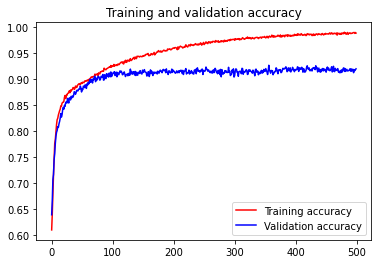

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

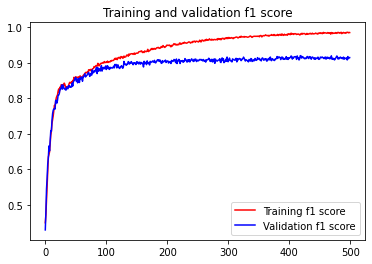

<Figure size 432x288 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']

epochs = range(len(f1))

plt.plot(epochs, f1, 'r', label='Training f1 score')
plt.plot(epochs, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
plt.legend(loc=0)
plt.figure()


plt.show()

In [36]:
# print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Test F1 score', f1_score)

Test accuracy: 0.9280433654785156
Test F1 score 0.9265438914299011


In [32]:
print('Max validation accuracy:', max(history.history['val_accuracy']))

Max validation accuracy: 0.9260355234146118


In [33]:
print('Max training accuracy:', max(history.history['accuracy']))

Max training accuracy: 0.9893977642059326


In [34]:
print('Max validation F1 score:', max(history.history['val_f1_score']))

Max validation F1 score: 0.9207363128662109


In [35]:
print('Max training F1 score:', max(history.history['f1_score']))

Max training F1 score: 0.9866169095039368
